In [31]:
#import jax
#import jax_metrics as jm
#import jax.numpy as jnp
#from jax import grad, jit, vmap
#from functools import partial


#from jax import random
import os
import numpy as jnp
import matplotlib.pyplot as plt# Switch off the cache 
from sklearn.metrics import confusion_matrix 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [32]:

    
#tenemos la matriz de pesos. Como tenemos la capa de input y una hidden, por eso tenemos dos pessos y dos bias
def retreive(model_dict):
    w1=model_dict['w1']
    b1=model_dict['b1']
    w2=model_dict['w2']
    b2=model_dict['b2']
    return w1,b1,w2,b2



    
def generate_w(k_classes, inpt_size,samples,hidden):
    """
    Use the random generator at Jax to generate a random generator to initialize the network
    """
    model={}
    #key = random.PRNGKey(0)
    #keys = random.split(key, 2)
    #w1=jnp.array(random.normal(keys[0], (hidden,inpt_size )))
    w1=jnp.random.rand(hidden,inpt_size)
    w2=jnp.random.rand(k_classes,hidden)
    #w1=(w1-jnp.min(w1))/(jnp.max(w1)-jnp.min(w1))
    #w2=jnp.array(random.normal(keys[1], (k_classes,hidden)))
    #w2=(w2-jnp.min(w2))/(jnp.max(w2)-jnp.min(w2))
    b1=jnp.zeros((hidden,1))
    b2=jnp.zeros((k_classes,1))
    model['w1']=w1
    model['b1']=b1
    model['w2']=w2
    model['b2']=b2
    return model 

def forward(x,model_dict):
    w1,b1,w2,b2=retreive(model_dict)
    #input to hidden
    z1=w1@x +b1#size -> (hidden,samples)
    a1=jnp.tanh(z1)
    #hidden to output
    z2=w2@a1+b2 #size -> (classes,samples) ****
  

    #and let's calculate the softmax applied to a2 because we'll need it in cross-entropy
    soft=jnp.exp(z2)/jnp.sum(jnp.exp(z2),axis=0) #size -> (classes, samples)

    return z1,a1,soft

def loss_function(y,soft):
    #loss=jnp.mean(jnp.sum(-y*jnp.log(soft),axis=0)) #loss is a number
    loss=jnp.mean(-y*jnp.log(soft))
    return loss

def backpropagation(x,y,model_dict,samples,learning_rate):
    w1,b1,w2,b2=retreive(model_dict) 
    z1,a1,soft=forward(x,model_dict)
    
    #output to hidden
    #first, lets calculate error
    dz2=soft-y #size -> (classes, samples)
    
    #now we calculate the derivative
    dw2=(1/samples)*dz2@jnp.transpose(a1) #size -> (classes, hidden)
    
    db2=(1/samples)*jnp.sum(dz2) #size -> (classes, 1)

    #hidden to input
    #first we calculate error
   
    dz1=(jnp.transpose(w2)@dz2)*(1-jnp.power(jnp.tanh(z1),2)) #size -> (hidden,samples)
    dw1=(1/samples)*dz1@jnp.transpose(x) #size -> (hidden,input)
    db1=(1/samples)*jnp.sum(dz1)
    

    w1+=-learning_rate*dw1
    b1+=-learning_rate*db1
    w2+=-learning_rate*dw2
    b2+=-learning_rate*db2
    
    #actualizamos el model
    model_dict={'w1':w1,'b1':b1,'w2':w2,'b2':b2}

    return model_dict

def prediction(soft): 
    return jnp.argmax(soft,axis=0)

def get_pr(k_classes,samples,clases,y0,y_hat):
    FP=0
    FN=0
    TP=0
    recall_list=[]
    precision_list=[]
    for k in range(k_classes):
        for i in range (samples):
            if y0[i]==clases[k] and y_hat[i]==clases[k]:
                TP+=1
            if y0[i]!=clases[k] and y_hat[i] == clases[k]:
                FP+=1
            if y0[i]==clases[k] and y_hat[i] != clases[k]:
                FN+=1
        if FP+TP!=0:
            precision_list.append(TP/(TP+FP))
        else:
            precision_list.append(0)
        if FN+TP!=0:
            recall_list.append(TP/(TP+FN))
        else:
            recall_list.append(0)

        
        
   
    precision=sum(precision_list)/k_classes
    recall=sum(recall_list)/k_classes
    return precision,recall








def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return jnp.sum(predictions == Y) / Y.size


def modelo(x,y,samples,learning_rate,max_step,k_classes,inpt_size,hidden,y_0,clases,stop):
    model_dict=generate_w(k_classes, inpt_size,samples,hidden)
    precision_list=[]
    recall_list=[]
    loss_list=[]
    loss=1
    for i in range(max_step):
        model_dict=backpropagation(x,y,model_dict,samples,learning_rate)
        soft=forward(x,model_dict)[2]
        old_loss=loss
        loss=loss_function(y,soft)
        loss_list.append(loss)
        
        if i%10==0:
            y_hat=prediction(soft)
            precision,recall=get_pr(k_classes,samples,clases,y_0,y_hat)
            precision_list.append(precision)
            recall_list.append(recall)
            
            ac=get_accuracy(y_hat,y_0)
            #print('La función de loss en la epoca {} es {:.3f}%, con un accuracy de {:.3f}%'
             #     .format(i,loss,ac))
            
            print(loss,i,precision,recall,ac)

        if  jnp.abs(loss-old_loss)<stop:
            
            break
    
        
    return recall_list,precision_list,loss_list,y_hat

def graficar_pr(recall_list,precision_list):
    plt.style.use('rose-pine')
    plt.plot(recall_list,precision_list,color='#fb9f9f',marker='*')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

def graficar_rc(loss_list):
    plt.style.use('rose-pine')
    plt.plot(loss_list,color='#fb9f9f')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Rate of Convergency')
    plt.show()
            





In [33]:
#before trying with MNIST lets try with something simpller
import sklearn.datasets
x,y=sklearn.datasets.make_moons(200,noise=0.15) #x are inputs and y are the expected labels
print(y)
x=jnp.transpose(x) #because we wrote the equations thinking that sizeX=(features,samples)
y=jnp.transpose(y)
y_0=y

[0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0
 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0
 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1]


In [34]:
import pandas as pd
df=pd.DataFrame(y,columns=['y'])
renglones=df['y'].shape[0]
df_categorical=df[['y']]
columnas=df_categorical.shape[1]
one_hot=jnp.zeros(renglones)

col=0
df2=pd.DataFrame()
df3=pd.DataFrame()
df3.insert(0,'1',one_hot)
for k in range(0,columnas):
    name=df_categorical.columns[k]
    print(name)
    lista=[]
    lista=df_categorical[name].values.tolist()
    clases=df_categorical[name].unique() #un array de las distintas clases
    size_clases=len(clases)
    
    
    for i in range(size_clases):
        clase=clases[i]
        print(clase)

        for j in range(0,renglones):
            if lista[j]==clase:
                one_hot[j]=1  
        
        df2.insert(i,clase,one_hot)
        
        one_hot=jnp.zeros(renglones)
    df3=df3.join(df2)
    df2=pd.DataFrame()
del df3[df3.columns[0]]
y=df3.to_numpy()
y=jnp.transpose(y)



y
0
1


la shape dey (2, 200)
0.32333738817011975 0 0.7221739130434783 0.505 0.64
0.24675560261923762 10 0.7654166666666666 0.75 0.76
0.19312075162846473 20 0.8206603773584906 0.845 0.83
0.17014374094491672 30 0.8631930693069307 0.8674999999999999 0.865
0.16117353514760235 40 0.8731435643564356 0.8775 0.875
0.15771522776944524 50 0.8768939393939394 0.8725 0.875
0.1562772481141434 60 0.8768939393939394 0.8725 0.875
0.15559306425159952 70 0.8768939393939394 0.8725 0.875
0.15520886503027367 80 0.8768939393939394 0.8725 0.875
0.15495379063179834 90 0.8768939393939394 0.8725 0.875
0.15475974440520524 100 0.8737755102040816 0.865 0.87
0.15459789574454702 110 0.8737755102040816 0.865 0.87
0.15445513722187246 120 0.8737755102040816 0.865 0.87
0.15432498030217012 130 0.8737755102040816 0.865 0.87
0.15420389813314495 140 0.8737755102040816 0.865 0.87
0.15408979324354607 150 0.8737755102040816 0.865 0.87
0.15398132004573956 160 0.8737755102040816 0.865 0.87
0.15387756367895292 170 0.8737755102040816 0.86

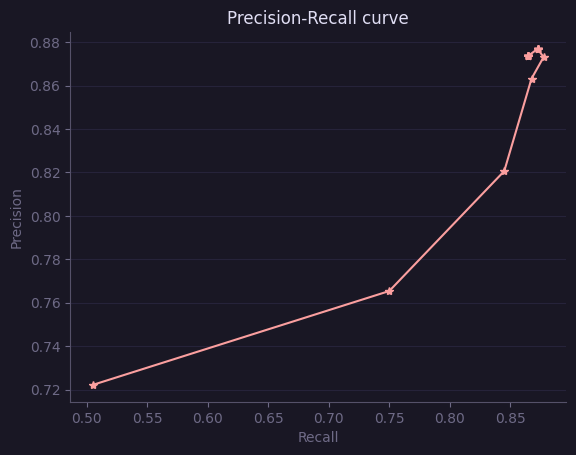

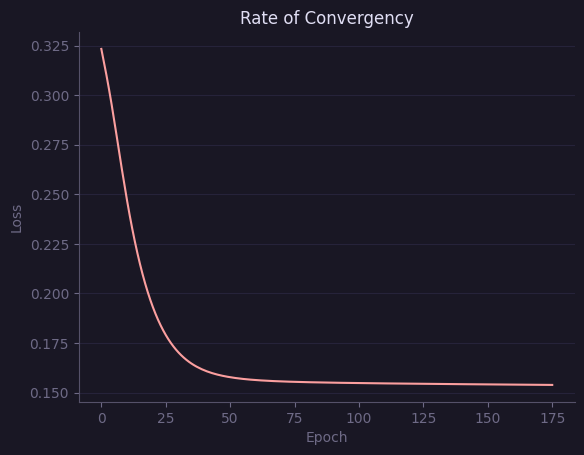

array([[86, 14],
       [12, 88]], dtype=int64)

In [47]:
#Now, we define the parameters for our neural network
samples=200
clases=jnp.array([0,1])
learning_rate=0.1
max_step=10000
k_classes=2
inpt_size=2
hidden=3
stop=0.00001
print('la shape dey',y.shape)
recall_list,precision_list,loss_list,y_hat=modelo(x,y,samples,learning_rate,max_step,k_classes,inpt_size,hidden,y_0,clases,stop)
graficar_pr(recall_list,precision_list)
graficar_rc(loss_list)
confusion_matrix(y_0,y_hat)


In [36]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds
data_dir = '/home/remote_code/Jax_Excercises/tfds'
#C:/Users/52333/Documents\doctorado\ml-md\tarea5\tfds

In [37]:
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

In [38]:
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [39]:
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))


In [40]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


In [41]:
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels_hot = one_hot(train_labels, num_labels)
print(train_images.shape)

(60000, 784)


In [42]:
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels_hot = one_hot(test_labels, num_labels)

In [43]:
train_images=jnp.transpose(train_images)
print(train_images.shape)
train_labels=jnp.transpose(train_labels)
train_labels_hot=jnp.transpose(train_labels_hot)
test_images=jnp.transpose(test_images)
test_labels=jnp.transpose(test_labels)
test_labels_hot=jnp.transpose(test_labels_hot)


(784, 60000)


In [51]:
samples=train_images.shape[1]
print(samples)
clases=jnp.array([0,1,2,3,4,5,6,7,8,9])
learning_rate=2
max_step=10000
k_classes=10
inpt_size=784
hidden=10
stop=0.00001
recall_list,precision_list,loss_list,y_hat=neural_net=modelo(train_images,train_labels_hot,samples,learning_rate,max_step,k_classes,inpt_size,hidden,train_labels,clases,stop)
graficar_pr(recall_list,precision_list)
graficar_rc(loss_list)
confusion_matrix(y_0,y_hat)

60000
0.2579317894231761 0 0.10113000000000003 0.21120125187002511 0.11236666666666667
0.23259981488461942 10 0.10113000000000003 0.21120125187002511 0.11236666666666667
0.2325727515623458 20 0.10113000000000003 0.21120125187002511 0.11236666666666667
0.23267246826649635 30 0.10113000000000003 0.21120125187002511 0.11236666666666667


KeyboardInterrupt: 